In [1]:
cd ..

/Users/mccullen/Dropbox/python/alphabet_complexity


In [2]:
# code adapted from these two sites:
# https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/
# https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
bs = 256

with open('data/PS_v2_32.pkl','rb') as f:
    PS = pickle.load(f)

PS = [(1-p[0],p[1]) for p in PS]
dl = torch.utils.data.DataLoader(dataset=PS, 
                                 batch_size=bs, 
                                 shuffle=False)


In [4]:
class ConvVAE(nn.Module):
    def __init__(self, init_channels, final_channels, latent_dim, hidden_dim):
        super(ConvVAE, self).__init__()
        image_channels = 1 # images are grayscale
        kernel_size = 4 # (4, 4) kernel
        self.init_channels = init_channels
        self.final_channels = final_channels
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=final_channels, kernel_size=kernel_size,
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(final_channels, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, final_channels)
        # decoder
        self.dec1 = nn.ConvTranspose2d(
            in_channels=final_channels, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1
        )
        if torch.cuda.is_available():
            self.cuda()

    def encoder(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        #hidden = torch.sigmoid(hidden)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        return hidden, mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        z = mu + (eps * std) # sampling
        z = self.fc2(z)
        z = z.view(-1, self.final_channels, 1, 1)
        return z

    def decoder(self, z):
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction

    def forward(self, x):
        hidden, mu, log_var = self.encoder(x)
        z = self.sample(mu, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var




vae = ConvVAE(init_channels = 16, # initial number of filters
              final_channels = 64,
              latent_dim = 64, # latent dimension for sampling
              hidden_dim = 128)


print('# parameters:',sum([np.prod(m.shape) for n,m in vae.named_parameters()]))
vae.load_state_dict(torch.load('models/vae.pt',map_location='cpu'))


# parameters: 431569


<All keys matched successfully>

In [5]:
%%time
rs=[]
for b,q in dl:
    r,_,_ = vae(b)
    rs.append(r)
    
rs = torch.cat(rs)[:,0]

CPU times: user 25.8 s, sys: 5.44 s, total: 31.3 s
Wall time: 8.95 s


In [6]:
%%time
hs=[]
for b,q in dl:
    h,_,_ = vae.encoder(b)
    hs.append(h)
    
hs = torch.cat(hs).detach().numpy()

CPU times: user 22.4 s, sys: 4.45 s, total: 26.9 s
Wall time: 7.93 s


In [110]:
list(dl)[0][0].shape

torch.Size([256, 1, 32, 32])

In [7]:
ls = [p[1] for p in PS]

In [8]:
vs = (hs.T/np.sqrt(np.sum(hs**2,axis=1))).T

for k in np.random.choice(range(len(ls)),20):
    v = vs[k]
    coss = np.inner(v,vs)
    print(ls[k]+'  ',' '.join([ls[k] for k in np.argsort(-coss)[1:20]]))

𔕟   ⩺ 𔘜 𓋄 𓃨 ಘ 𓊃 𓆟 𓆢 𓐈 𓄡 ⪧ 𔐦 𓅈 ⇦ 𔐷 ᢶ 𔓥 𔐻 𖡰
ఘ   ಮ ఝ ﶏ ೠ 𔑁 ﶒ ﶎ ﶊ 𐦘 ಋ మ ﷴ ඐ ﵓ ﶕ ﲷ ﵜ ﵣ 𞢅
䷪   ䷹ ䷄ ䷰ ䷡ ䷛ Ⲷ ䷀ ䷾ ䷵ ䷉ ䷌ ䷍ ䷊ ䷯ ䷈ ䷶ ䷐ ䷮ ䷫
ﰘ   ﰖ ﰪ ﲉ ꤻ ﰛ ﱈ ﱒ ﰟ ﰡ ﰎ ﱲ ﱎ ﰬ ﰥ ﵶ 𓂷 ⭁ ⼾ 𓌽
⇔   ⤃ ⇐ ⤂ ⇒ 林 𖨔 ⟸ ⥰ ᤻ ⟺ ॒ ⬄ 𓄡 ┄ ⇎ ⟹ 﨨 ≁ ⤇
ڞ   ﺽ ض ﱼ ﴟ ﳹ ﺾ ﴃ ﱾ ﴕ ﺶ ݰ ﱓ ﳷ ﳽ ﳵ ݽ ﴙ ﴑ ﰵ
ዸ   ደ Ệ ᛟ ꬎ ꬍ ₂ ꫳ ẋ 𖦔 𐔰 ၩ 𖦂 ዹ ጳ ᒾ ⼳ ƙ ጶ 𐰋
𓏝   𓏛 𓀿 𓂫 𓂧 𓁺 𓏕 𓂻 𓀁 𓃺 𓁻 𔘞 𓀩 𔑅 ⥦ 𓄖 𓃹 𓂩 ░ 𓃗
्   ্ 𑓂 ꤧ ݈ ⸜ 𑑂 ⸌ 𑂹 ୍ 𑇌 ꠦ ` 𑋪 ᳭ 𑘿 ꯥ 𑂵 ‵ ꠬
ṗ   Ṗ Ṕ Ḟ Ꝧ ₚ ᵖ ᵽ p ṕ Ϸ ｐ ᱞ þ ꝑ Þ р ϼ ƥ ꝥ
𖥟   𖢭 ⧾ 𖥤 𖢅 ╬ ╋ 𖡒 𖥠 𖡟 ╈ ╇ 𑁕 ⊹ 𖧐 ╊ 𖤛 𖢌 ╄ ⍖
𓋈   𓋇 𓇣 𓊿 𔒴 𓉦 𓍬 𓋁 𓍴 𓋹 𓋂 𓎞 𔗬 𓅈 𔕴 𓌂 𓋀 𓍚 𓇉 𓄸
ᵎ   ᴉ 𑘰 ᛙ ₗ ļ ḷ ᶦ ɪ ᴵ ḹ ı ī Ị ꞁ ị ༙ 𞠩 𞠦 །
𓂾   𓁄 𓐕 𓌳 𓀊 𓌴 𓋓 𓃁 𓌚 𓎝 𓌶 𓌵 𓍌 𓋲 ᜵ 𓋶 𓀠 𓀣 𓌉 𓀖
𑆚   ԋ ꠚ ⻏ њ 𑐪 ѭ ꤒ 𑐯 ꠢ Ԋ 玲 𞤿 ₨ 瑱 ꝴ 𑐤 ㎩ ꯃ 珞
ᓏ   ᓋ 𖬹 𑒳 ᄘ ㅥ ሿ ㅻ ܞ ᇵ ኴ ቯ ೩ ᇍ 𐮐 ᄔ 𐫬 ܧ ጟ ᾱ
ᢁ   ᇮ ᪲ 𐫢 ∞ თ ꭄ ൢ ᅇ 𐫲 ꝏ ܗ ၹ 𐫖 ꩅ ᪼ ᳹ ⧜ 𑅮 ૿
ヂ   ブ 𔓍 ゾ ↶ デ ༼ ㌩ ⺹ ⌿ 𖤆 𓁤 ᚋ プ ㆷ ↗ ਿ 𓎝 ジ ⁄
ሒ   ሔ ሑ ሗ 𞟢 𞟨 𞟡 ᕕ ꬣ 𖢑 ꬠ 𞟤 ሌ 𞟫 ᕖ ஃ ൔ ꬡ 𞟩 𑃍
𑐑   𑘑 𑆡 𑆥 𑒠 𑐲 𑒪 𑐥 𑐧 𑐔 𑘬 ॺ 𑐣 ᤄ ਥ ꠛ 𑒒 𑐰 त ઘ


In [88]:
abcs = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
abcs=abcs.lower()
v_abcs = np.array([v for l,v in zip(ls,vs) if l in abcs])
l_abcs = [l for l in ls if l in abcs]
coss = np.inner(v_abcs,v_abcs)
nears = [-np.sort(-c)[1] for c in coss]
nnears = [np.argsort(-c)[1] for c in coss]
for k in np.argsort(nears):
    print(l_abcs[k],' ',l_abcs[nnears[k]],' ',np.round(nears[k],2))

m   w   0.5
q   u   0.59
w   v   0.63
g   z   0.64
v   y   0.64
p   r   0.65
y   r   0.66
x   z   0.7
z   x   0.7
j   d   0.72
f   r   0.74
r   f   0.74
t   i   0.74
d   a   0.76
s   a   0.81
a   s   0.81
n   u   0.83
u   n   0.83
k   h   0.83
o   c   0.84
h   b   0.84
b   h   0.84
i   l   0.94
l   i   0.94
e   c   0.95
c   e   0.95


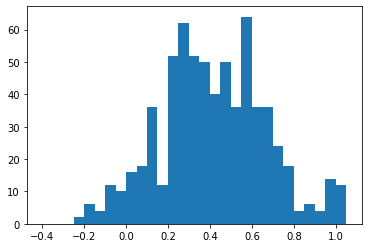

In [122]:
plt.hist(coss.flatten(),bins=np.arange(-.4,1.1,.05))
plt.show()

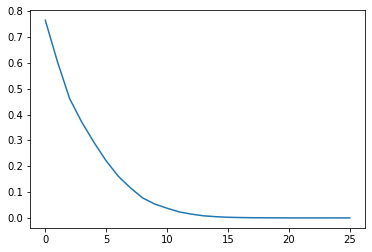

In [89]:
from sklearn.decomposition import PCA
pca = PCA(n_components=26)
pca.fit(v_abcs)
plt.plot(1-np.inner(np.tril(np.ones((26,26))),pca.explained_variance_ratio_))
#plt.plot(pca.singular_values_)


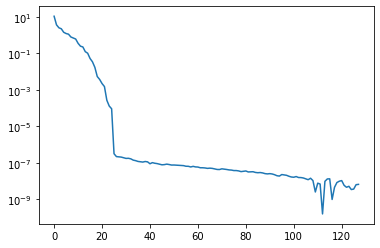

In [146]:
plt.plot(np.abs(np.linalg.eig(np.inner(v_abcs.T,v_abcs.T))[0]))
plt.yscale('log')

In [9]:
import pandas as pd
scripts = pd.read_pickle('data/dfu_v2.pkl').script.to_list()

In [10]:
from collections import Counter
scriptcounts=Counter(scripts)


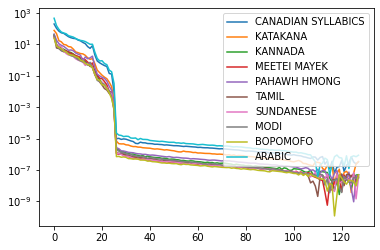

In [165]:
script = 'SINHALA'
for script in np.random.choice(list(set(scripts)),10,replace=False):
    v_script = np.array([v for s,v in zip(scripts,vs) if s==script])
    plt.plot(np.abs(np.linalg.eig(np.inner(v_script.T,v_script.T))[0]),
             label=script)
plt.yscale('log')
plt.legend()
plt.show()

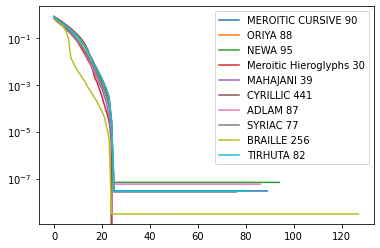

In [91]:


for script in np.random.choice(list(set(scripts)),10,replace=False):
    v_script = np.array([v for s,v in zip(scripts,vs) if s==script])
    l = min(v_script.shape)
    pca = PCA(n_components=l)
    pca.fit(v_script)
    plt.plot(1-np.inner(np.tril(np.ones((l,l))),
                        pca.explained_variance_ratio_),
            label=script+' '+str(v_script.shape[0]))
plt.yscale('log')
#plt.xlim(0,30)
plt.legend(bbox_to_anchor=(1,1))
plt.show()


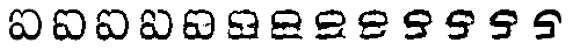

In [232]:
k1 = 4848
k2 = 2262
hidden = np.array([x*hs[k1]+(1-x)*hs[k2] for x in np.arange(0,1.1,.1)])
hidden = torch.Tensor(hidden)

mu = vae.fc_mu(hidden)
log_var = vae.fc_log_var(hidden)
z = vae.sample(mu,log_var)

with torch.no_grad():
    sample = vae.decoder(z).cpu().detach().numpy()

fig, axs = plt.subplots(1,2+len(hidden), figsize=(10, 5))


for n in range(len(hidden)):
    a=axs[n+1]
    a.imshow(1-sample[n,0]>.6,cmap='gray')
    a.axis('off')
axs[0].imshow(1-PS[k2][0][0],cmap='gray')
axs[-1].imshow(1-PS[k1][0][0],cmap='gray')
axs[0].axis('off')
axs[-1].axis('off')

plt.show()

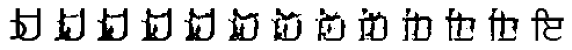

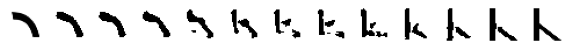

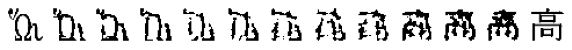

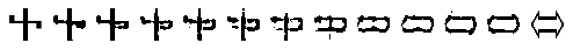

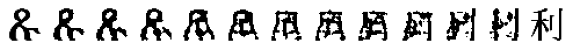

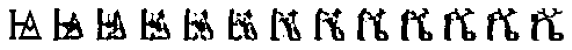

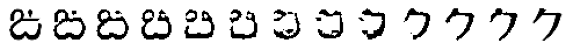

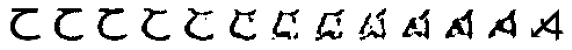

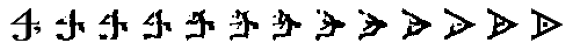

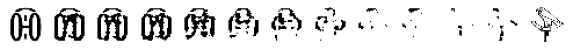

In [261]:
for _ in range(10):
    k1, k2 = np.random.choice(range(len(hs)),2)
    hidden = np.array([x*hs[k1]+(1-x)*hs[k2] for x in np.arange(0,1.1,.1)])
    hidden = torch.Tensor(hidden)

    mu = vae.fc_mu(hidden)
    log_var = vae.fc_log_var(hidden)
    z = vae.sample(mu,log_var)

    with torch.no_grad():
        sample = vae.decoder(z).cpu().detach().numpy()

    fig, axs = plt.subplots(1,2+len(hidden), figsize=(10, 5))


    for n in range(len(hidden)):
        a=axs[n+1]
        a.imshow(1-sample[n,0]>.6,cmap='gray')
        a.axis('off')
    axs[0].imshow(1-PS[k2][0][0],cmap='gray')
    axs[-1].imshow(1-PS[k1][0][0],cmap='gray')
    axs[0].axis('off')
    axs[-1].axis('off')

    plt.show()

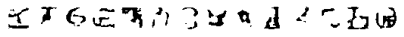

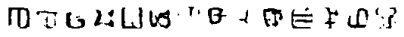

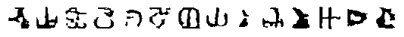

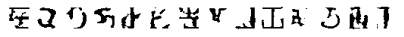

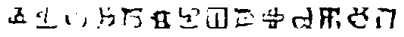

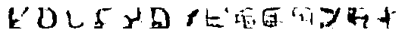

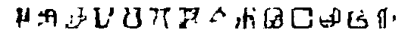

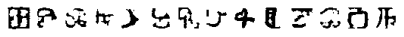

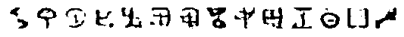

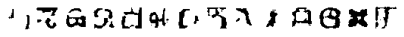

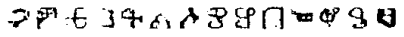

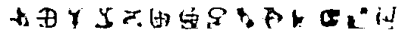

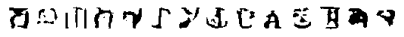

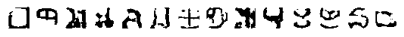

In [226]:
# generate random characters
N=14
for _ in range(14):

    hidden = torch.randn(N,vae.hidden_dim)

    mu = vae.fc_mu(hidden)
    log_var = vae.fc_log_var(hidden)
    z = vae.sample(mu,log_var)

    with torch.no_grad():
        sample = vae.decoder(z).cpu().detach().numpy()

    fig, axs = plt.subplots(1,N, figsize=(7, 5))

    for n in range(N):
        a=axs[n]
        a.imshow(1-sample[n,0]>.6,cmap='gray')
        a.axis('off')
    plt.show()